 # Gaussian Mixtures and VI
 
 

 Using the paper :
 **Variational Inference: A Review for Statistician**
 https://arxiv.org/abs/1601.00670
 
 Krissaane ines
 
 
 March 29, 2019

In [1]:
import numpy as np
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns

## Gaussian mixture model 

In [2]:
def covariance(sigma1=1., sigma2=1., theta=0.):
    """
        Covariance matrix with eigenvalues sigma1 and sigma2, rotated by the angle theta.
    """
    rotation = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])
    cov = np.array([[sigma1, 0.],
                   [0, sigma2]])
    return rotation.dot(cov.dot(rotation.T))

In [3]:
def sample_gm(weights, means, covariances, size=1):
    """Sample points from a Gaussian mixture model specified by the weights, the means
    and the covariances. These three parameters are lists."""
    X = None
    p = np.random.multinomial(1, weights, size=size)
    for (m, c, i) in zip(means, covariances, p.T):
        Y = np.random.multivariate_normal(m, c, size=size)
        if X is None:
            X = Y.copy()
        else:
            X[i==1] = Y[i==1]
    return X

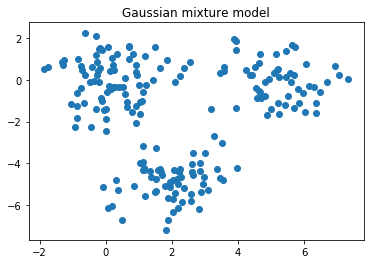

In [4]:
(weights, means, covariances) = ([0.33, 0.33, 0.34],
                                 [[0, 0], [5, 0], [2, -5]],
                                 [(1, 1, 0), (1, 1, 0), (1, 1, np.pi/2)])

X = sample_gm(weights, means, [covariance(*c) for c in covariances], size=200)

plt.scatter(X[:,0], X[:, 1]);
plt.title('Gaussian mixture model');

## Variational Inference

### A concrete example : Bayesian mixture of Gaussians

Let's consider samples from mixtures of Gaussian distributions. 

We have $K$  Gaussian distributions with means $\mathbf{\mu} = { \mu_1, …, \mu_K }$ and unit variance ($\mathbf{\sigma}=\mathbf{1}$)


$\mu_{k} \sim \mathcal{N}(0, \sigma^{2} ),   \hspace{+5cm}  k = 1,...,K$

$c_{i} \sim  Categorical(\frac{1}{K}, ..., \frac{1}{K}),  \hspace{+2.5cm}   i = 1,...,n$

$x{i}\vert c_{i} ,\mu \sim  \mathcal{N}(c_{i}^{T}\mu , 1 ),     \hspace{+4cm}  i=1,...,n$


The joint probability can be written out :

\begin{align} p(\mathbf{c}, \mathbf{\mu}, \mathbf{x}) = p(\mathbf{\mu})p(\mathbf{c})p(\mathbf{x} \vert \mathbf{c}, \mathbf{\mu}) \\  = p(\mathbf{\mu}) \prod_{i} p(c_{i})p(x_{i}\vert c_{i}, \mathbf{\mu}) \end{align} 

The latent variables are z={$\mu$, c}, the K class means and n class assignments.

Some transformations that might be hepful in the following :

\begin{align} log~p(\mathbf{c}, \mathbf{\mu}, \mathbf{x}) = \sum_j log~p(\mu_j) + \sum_i \big[ log~p(c_i) + log~p(x_i~\vert~c_i, \mu) \big] \\ \end{align} 



$p(c_i) = \dfrac{1}{K}$ is a constant and $\begin{align} log~p(\mu_j) = log~\Big\{ \dfrac{1}{\sqrt{2\pi \sigma^2}} exp\big[ -\dfrac{\mu_j^2}{2\sigma^2} \big] \Big\}   \propto -\dfrac{\mu_j^2}{2\sigma^2} \end{align}$


$log~p(x_i~\vert~c_i, \mu) = log~\prod_j p(x_i~\vert~\mu_j)^{c_{ij}} = \sum_j c_{ij} log~p(x_i~\vert~\mu_j) = \sum_j c_{ij}  log~\Big\{ \dfrac{1}{\sqrt{2\pi}} exp\big[ -\dfrac{(x_i-\mu_j)^2}{2} \big] \Big\} \propto \sum_j -\dfrac{(x_i-\mu_j)^2}{2}c_{ij}$


**Conclusion**  

$$log~p(x, c, \mu) \propto \sum_j -\dfrac{\mu_j^2}{2\sigma^2} + \sum_i\sum_j -\dfrac{(x_i-\mu_j)^2}{2}c_{ij} \hspace{+2cm} (1)$$ 

In [13]:
n = 100
mu = np.array([-30, -10, 13])
mu
X = np.array([])
for i in mu :
    X = np.append(X,np.random.normal(loc=i, scale=1, size=n))

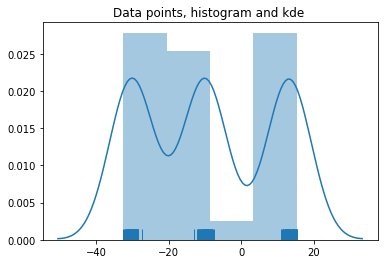

In [14]:
plot = sns.distplot(X,  rug=True);
plot.set_title('Data points, histogram and kde ');

Gaussian mixtures Model


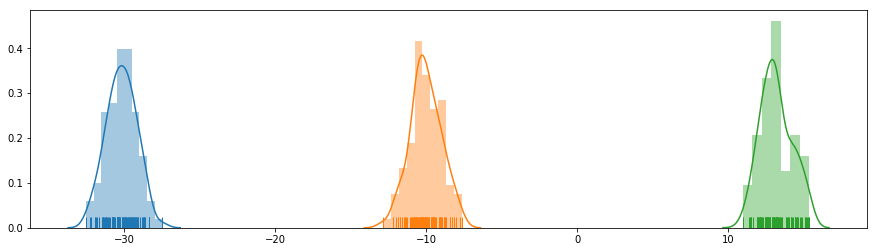

In [15]:
fig = plt.subplots(figsize=(15, 4))
sns.distplot(X[:n],  rug=True)
sns.distplot(X[n:n*2], rug=True)
sns.distplot(X[n*2:], rug=True);
print('Gaussian mixtures Model');

We can obtain the marginal likelihood $p(\mathbf{x})$ :
\begin{align} p(\mathbf{x}) = \int_{\mathbf{\mu}} p(\mathbf{\mu}) \prod_{i} \sum_{c_{i}} p(c_{i})p(x_{i} \vert c_{i}, \mathbf{\mu}) d \mathbf{\mu}\\= \sum_{\mathbf{c}} p(\mathbf{c}) \int_{\mathbf{\mu}} p(\mathbf{\mu}) \prod_{i} p(x_{i} \vert c_{i}, \mathbf{\mu}) d \mathbf{\mu} \end{align} 


The overall complexity will go up to $\mathcal{O}(K^n)$, let's consider approximate inference due to the intractability.

#### The evidence lower bound

We introduce a new approximation function  $q_\phi(\mathbf{z}\vert\mathbf{x})$, parameterized by $\phi$  within a tractable parametric family such that $q(\mathbf{z}\vert\mathbf{x})= q(\mathbf{z}\vert\mathbf{x}, \phi^{*})$ ;
$\phi^{*} = \operatorname*{argmin}_\phi KL(q(\mathbf{z}\vert\mathbf{x}, \phi) || p(\mathbf{z}\vert\mathbf{x}) )$ and the evidence lower bound (**ELBO**) is defined by :



\begin{align*}
\mathcal{L} &= \mathbb{E}_q\big[ \log{p(x,z)} - \log{q_\phi(z)} \big] \\
&= \mathbb{E}_q\big[ \log{p(x|z)} \big] - KL(q(z)||p(z)) 
\end{align*}


#### The mean-field variational family for mixture-component means 

In the paper, they focused on the mean-field variational family, where the latent variables are mutually independant :

$$q(\mathbf{z}) = \prod_{j} q_j(z_j)$$

So we will choose the following variational distributions for $c$ and $\mu$ in our example st:

$$q(\mu, c) = q(\mu;m, s^2)~q(c; \phi) = \prod_j q(\mu_j; m_j, s_j^2)~\prod_i q(c_i; \phi_i)$$

where:

\begin{align} \mu_j; m_j, s_j^2 \sim \mathcal{N}(m_j, s_j^2) \\ c_i; \phi_i  \sim Multi(\phi_i) \end{align} 

$\phi_i$ is a vector of probabilities  $p(c_i=j) = \phi_{ij}$

We have :
 
$$log~q(c, \mu) = \sum_i log~p(c_i; \phi_i) + \sum_j log~p(\mu_j; m_j, s_j^2)$$


where : $log~p(c_i; \phi_i) = log~\prod_j p(c_i=j; \phi_i) = \sum_j log~\phi_{ij}$

$\begin{align} log~p(\mu_j; m_j, s_j^2) = log~\Big\{ \dfrac{1}{\sqrt{2\pi s_j^2}} exp \big[ -\dfrac{(\mu_j-m_j)^2}{s_j^2} \big] \Big\} \\ = -\dfrac{1}{2}log~(2\pi s_j^2) -\dfrac{(\mu_j-m_j)^2}{s_j^2} \end{align}$

Therefore, we have:

$$log~q(c, \mu) \propto \sum_i \sum_j log~\phi_{ij} + \sum_j -\dfrac{1}{2}log~(2\pi s_j^2) -\dfrac{(\mu_j-m_j)^2}{s_j^2}\hspace{+2cm} (2) $$ 
    
    

#### Parameters update (CAVI algorithm)

So we want to maximize the ELBO ;

$$\mathcal{L} = \mathbb{E}_q\big[ \log{p(x,z)} - \log{q_\phi(z)} \big] $$

Using (1) and (2), we obtain : 

\begin{align} ELBO \propto  \sum_j -E_q\Big[\dfrac{\mu_j^2}{2\sigma^2}\Big] + \sum_i\sum_j ~\phi_{ij}E_q\Big[-\dfrac{(x_i-\mu_j)^2}{2}\Big] \\- \sum_i \sum_j E_q\Big[log~\phi_{ij}\Big] + \sum_j \dfrac{1}{2}log~(s_j^2) + 0 \end{align}
    
    

* $\phi_{ij}$*


\begin{align} \dfrac{\partial}{\partial \phi_{ij}}~ELBO \propto \dfrac{\partial}{\partial \phi_{ij}}\Big\{E_q\Big[-\dfrac{(x_i-\mu_j)^2}{2}\Big] \phi_{ij} - E_q\Big[log~\phi_{ij}\Big] \Big\} \\   log~\phi_{ij}  \propto E_q\Big[-\dfrac{(x_i-\mu_j)^2}{2}\Big] \\ \phi_{ij}^*  \propto exp\{ -\tfrac{1}{2}(m_j^2+s_j^2) + x_i m_j \} \end{align} 



* $m_j$* 

\begin{align} \dfrac{\partial}{\partial m_{j}}~ELBO \propto \dfrac{\partial}{\partial m_{j}}~\Big\{ -E\big[\dfrac{\mu_j^2}{2\sigma^2}\big] - \sum_i \phi_{ij} E[\dfrac{(x_i-\mu_j)^2}{2}] \Big\} \\  \propto \dfrac{\partial}{\partial m_{j}}~\Big\{ -\dfrac{1}{2\sigma^2} m_j^2 + \sum_i \phi_{ij} \big[ -\dfrac{1}{2}m_j^2 + x_i m_j \big] \Big\} \\ = -\dfrac{1}{\sigma^2}m_j - \sum_i\phi_{ij} m_j + \sum_i \phi_{ij} x_i = 0 \\ m_j^* = \dfrac{\sum_i\phi_{ij}x_i}{\tfrac{1}{\sigma^2} + \sum_i\phi_{ij}} \end{align} 



* $s_j^2$ * 
    
$$\begin{align} \dfrac{\partial}{\partial s_j^2}~ELBO \propto \dfrac{\partial}{\partial s_j^2}~ \big\{ -E \big[\dfrac{\mu_j^2}{2\sigma^2}\big] - \sum_i \phi_{ij} E[\dfrac{(x_i-\mu_j)^2}{2}] +\dfrac{1}{2}log~s_j^2 \big\} \\  \propto \dfrac{\partial}{\partial s_j^2}~ \Big\{ -\dfrac{1}{2\sigma^2}s_j^2 - \sum_i\phi_{ij}(\dfrac{1}{2}s_j^2) +\dfrac{1}{2}log~s_j^2 \Big\} \\ 
= -\dfrac{1}{\sigma^2} - \sum_i \phi_{ij} + \dfrac{1}{s_j^2} = 0 \\ (s_j^2)^{*}= \dfrac{1}{\frac{1}{\sigma^2} + \sum_i\phi_{ij}} \end{align}$$



### CAVI for a mixture of gaussians

See algorithm page 14.


\begin{align} ELBO \propto  \sum_j (-E_q\Big[\dfrac{\mu_j^2}{2\sigma^2}\Big] +  \dfrac{1}{2}log~(s_j^2)) +\sum_i\sum_j (~\phi_{ij}E_q\Big[-\dfrac{(x_i-\mu_j)^2}{2}\Big] - E_q\Big[log~\phi_{ij}\Big]) := t1 + t2\end{align}
    
    

In [16]:
class CAVI_GMM(object):
    '''CAVI for a Gaussian mixture model'''
    def __init__(self, X, K=2, sigma=1):
        self.X = X
        self.K = K
        self.N = self.X.shape[0]
        self.sigma2 = sigma**2

    def _init(self):
        self.phi = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*self.K, self.N) 
        #https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.dirichlet.html
        self.m = np.random.randint(int(self.X.min()), high=int(self.X.max()), size=self.K).astype(float) 
        self.s2 = np.ones(self.K) * np.random.random(self.K)
    
    def elbo(self):
        t1 = (np.log(self.s2) - self.m**2 /self.sigma2).sum()
        t2 = (((-np.add.outer(self.X**2, self.s2+self.m**2) + np.outer(self.X, self.m) - 2*np.log(self.phi)) * self.phi)).sum()
        return (t1+t2)
    
    def cavi(self):
        self.new_phi()
        self.new_mu()
       
    def new_phi(self):
        exponent = np.outer(self.X, self.m)  -0.5*(self.m**2 + self.s2)[np.newaxis, :]
        self.phi = np.exp(exponent)
        self.phi = self.phi / self.phi.sum(1)[:, np.newaxis]


    def new_mu(self):
        self.m = (self.phi*self.X[:, np.newaxis]).sum(0) * (1/self.sigma2 + self.phi.sum(0))**(-1)
        self.s2 = (1/self.sigma2 + self.phi.sum(0))**(-1)

    def fit(self, max_iter=50, tol=1e-5):
        self._init()
        self.elbo_values = [self.elbo()]
        self.m_old = [self.m]
        self.s2_old = [self.s2]
        
        for iter_ in range(1, max_iter+1):
            self.cavi()
            self.m_old.append(self.m)
            self.s2_old.append(self.s2)
            self.elbo_values.append(self.elbo())
            if np.abs(self.elbo_values[-2] - self.elbo_values[-1]) <= tol:
                print('ELBO converged with ll %.3f with  %d iterations'%(self.elbo_values[-1],
                                                                     iter_))
                break

        if iter_ == max_iter:
            print('ELBO ended with ll %.3f'%(self.elbo_values[-1]))



In [17]:
cavi_gmm =  CAVI_GMM(X, 3)
cavi_gmm.fit()

ELBO ended with ll nan


/Users/ines_admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/Users/ines_admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


In [18]:
sorted(cavi_gmm.m)

[-29.863117124408067, -9.919429595666056, 13.05843547839082]

In [25]:
sorted(cavi_gmm.s2)

[0.009900990099009901, 0.009900990099009901, 0.009900990099009901]

In [19]:
sorted(mu)

[-30, -10, 13]

In [20]:
cavi_gmm.phi.argmax(1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [21]:
cavi_gmm.s2

array([0.00990099, 0.00990099, 0.00990099])

In [22]:
cavi_gmm.m[2]

-29.863117124408067

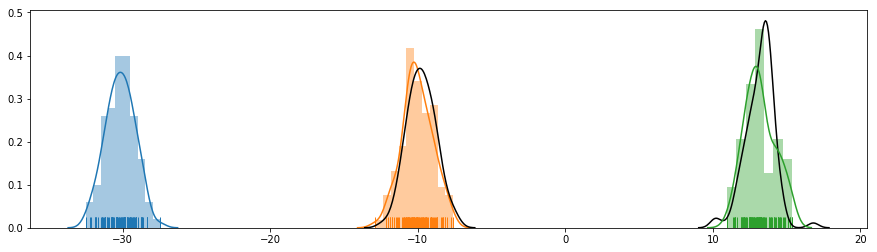

In [23]:
fig = plt.subplots(figsize=(15, 4))
sns.distplot(X[:n],  rug=True)
sns.distplot(np.random.normal(cavi_gmm.m[0], 1, n), color='k', hist=False, kde=True)
sns.distplot(X[n:n*2], rug=True)
sns.distplot(np.random.normal(cavi_gmm.m[1], 1, n), color='k', hist=False, kde=True)
sns.distplot(X[n*2:], rug=True);
#sns.distplot(np.random.normal(cavi_gmm.m[2], 1, n), color='k', hist=False, kde=True)